In [22]:
"""
Duopoly model
"""

import numpy as np
from itertools import product
from scipy.optimize import fsolve


class model(object):
    """
    model

    Attributes
    ----------
    n : int
        number of players
    alpha : float
        product differentiation parameter
    beta : float
        exploration parameter
    delta : float
        discount factor
    mu : float
        product differentiation parameter
    a : int
        value of the products
    a0 : float
        value of the outside option
    c : float
        marginal cost
    k : int
        dimension of the grid
    stable: int
        periods of game stability
    """

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.n = kwargs.get('n', 2) #the default n=2 has two players in an duopoly model
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0) #the discount factor that can be modified (i.e., in the range of: 0.05, 0.5 and 0.95)
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.k = kwargs.get('k', 15)
        self.tstable = kwargs.get('tstable', 1e5)
        self.tmax = kwargs.get('tstable', 1e7)

        # Derived properties
        self.sdim, self.s0 = self.init_state()
        self.p_minmax = self.compute_p_competitive_monopoly()
        self.A = self.init_actions()
        self.PI = self.init_PI()
        self.Q = self.init_Q()

    def demand(self, p):
        """Computes demand"""
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    def foc(self, p):
        """Compute first order condition"""
        d = self.demand(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu
        return np.squeeze(zero)

    def foc_monopoly(self, p):
        """Compute first order condition of a monopolist"""
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu + (p1 - self.c) * d1 / self.mu
        return np.squeeze(zero)

    def compute_p_competitive_monopoly(self):
        """Computes competitive and monopoly prices"""
        p0 = np.ones((1, self.n)) * 3 * self.c
        p_competitive = fsolve(self.foc, p0)
        p_monopoly = fsolve(self.foc_monopoly, p0)
        return p_competitive, p_monopoly

    def init_actions(self):
        """Get action space of the firms"""
        a = np.linspace(min(self.p_minmax[0]), max(self.p_minmax[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        return A

    def init_state(self):
        """Get state dimension and initial state"""
        sdim = (self.k, self.k)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0

    def compute_profits(self, p):
        """Compute payoffs"""
        d = self.demand(p)
        pi = (p - self.c) * d
        return pi

    def init_PI(game):
        """Initialize Profits (k^n x kp x n)"""
        PI = np.zeros(game.sdim + (game.n,))
        for s in product(*[range(i) for i in game.sdim]):
            p = np.asarray(game.A[np.asarray(s)])
            PI[s] = game.compute_profits(p)
        return PI

    def init_Q(game):
        """Initialize Q function (n x #s x k)"""
        Q = np.zeros((game.n,) + game.sdim + (game.k,))
        for n in range(game.n):
            pi = np.mean(game.PI[:, :, n], axis=1 - n)
            Q[n] = np.tile(pi, game.sdim + (1,)) / (1 - game.delta)
        return Q


In [23]:
"""
Q-learning Functions
"""

import sys
import numpy as np


def pick_strategies(game, s, t):
    """Pick strategies by exploration vs exploitation"""
    a = np.zeros(game.n).astype(int)
    pr_explore = np.exp(- t * game.beta)
    e = (pr_explore > np.random.rand(game.n))
    for n in range(game.n):
        if e[n]:
            a[n] = np.random.randint(0, game.k)
        else:
            a[n] = np.argmax(game.Q[(n,) + tuple(s)])
    return a


def update_q(game, s, a, s1, pi, stable):
    """Update Q matrix"""
    for n in range(game.n):
        subj_state = (n,) + tuple(s) + (a[n],)
        old_value = game.Q[subj_state]
        max_q1 = np.max(game.Q[(n,) + tuple(s1)])
        new_value = pi[n] + game.delta * max_q1
        old_argmax = np.argmax(game.Q[(n,) + tuple(s)])
        game.Q[subj_state] = (1 - game.alpha) * old_value + game.alpha * new_value
        # Check stability
        new_argmax = np.argmax(game.Q[(n,) + tuple(s)])
        same_argmax = (old_argmax == new_argmax)
        stable = (stable + same_argmax) * same_argmax
    return game.Q, stable


def check_convergence(game, t, stable):
    """Check if game converged"""
    if (t % game.tstable == 0) & (t > 0):
        sys.stdout.write("\rt=%i" % t)
        sys.stdout.flush()
    if stable > game.tstable:
        print('Converged!')
        return True
    if t == game.tmax:
        print('ERROR! Not Converged!')
        return True
    return False



def simulate_game(game):
    """Simulate game while recording exploration rate and profits at each timestep"""
    s = game.s0
    stable = 0
    exploration_rates = []  # List to record exploration rate at each timestep
    action_history = []      # Record actions (prices)    # Iterate until convergence
    for t in range(int(game.tmax)):
        a = pick_strategies(game, s, t)
        pr_explore = np.exp(- t * game.beta)
        exploration_rates.append(pr_explore)  # Record the exploration rate
        pi = game.compute_profits(game.A[np.asarray(a)])  
        p = game.A[a]  
        action_history.append(p.copy())      
        s1 = a
        game.Q, stable = update_q(game, s, a, s1, pi, stable)
        s = s1
        if check_convergence(game, t, stable):
            break
    return t, game, np.array(exploration_rates),action_history

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Number of simulations
num_simulations = 1 #possible to edit the number of simulations as desired

# List to store results of each simulation
results = []


game = model()
iterations, game, exploration_rates, action_history = simulate_game(game)

t=2000000Converged!


In [25]:
def plot_price_over_time(action_history, max_points=1000):
    """
    绘制每个玩家的价格随时间变化的图，通过动态调整时间步间隔以控制数据点数量。

    参数:
    - action_history: 一个 NumPy 数组，形状为 (时间步数, 玩家数量)
    - max_points: 绘图时最多的数据点数
    """
    total_steps = action_history.shape[0]
    n_players = action_history.shape[1]
    
    # 计算时间步间隔
    interval = max(1, total_steps // max_points)
    
    time_steps = np.arange(0, action_history.shape[0], interval)
    sampled_prices = action_history[::interval]
    
    plt.figure(figsize=(12, 6))
    for player in range(n_players):
        plt.plot(time_steps, sampled_prices[:, player], linestyle='-', label=f'player{player+1}price')
    
    plt.xlabel('time')
    plt.ylabel('p')
    plt.legend()
    plt.grid(True)
    plt.show()

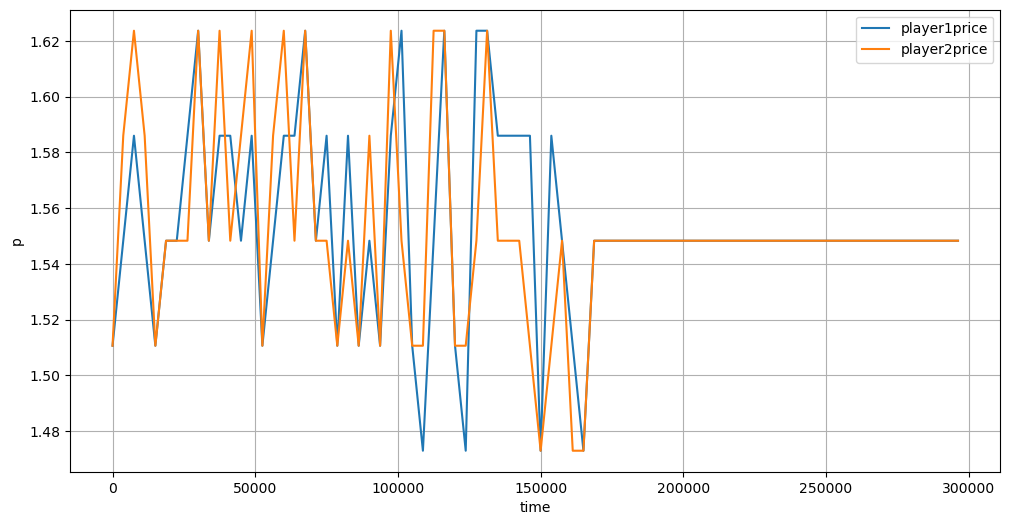

In [36]:
plot_price_over_time(np.asanyarray(action_history[-300000:]),80)

In [39]:
game.compute_p_competitive_monopoly()

(array([1.47292666, 1.47292666]), array([1.92498092, 1.92498092]))

In [41]:
game.A

array([1.43525547, 1.47292666, 1.51059785, 1.54826904, 1.58594022,
       1.62361141, 1.6612826 , 1.69895379, 1.73662498, 1.77429617,
       1.81196735, 1.84963854, 1.88730973, 1.92498092, 1.96265211])